In [76]:
# -------------------------------
# IMPORTS
# -------------------------------
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [77]:
# -------------------------------
# PREPROCESSING FUNCTION (your friend's code)
# -------------------------------
def convert_range_to_midpoint(value):
    """
    Cleans a string, converts ranges to their midpoint, and handles various formats.
    """
    s = str(value).lower()
    s = s.replace('$', '').replace(',', '').replace('+', '')
    s = re.sub(r'k', '000', s)

    if '-' in s:
        try:
            parts = s.split('-')
            start = float(parts[0].strip())
            end = float(parts[1].strip())
            return (start + end) / 2
        except (ValueError, IndexError):
            return 0
    
    try:
        return float(s.strip())
    except ValueError:
        return 0


def preprocessing_data(df, target_col="Churn", drop_cols=[], categorical_encoder='ordinal'):
    print("🔧 Starting Preprocessing...")

    all_cols_to_drop = [col for col in df.columns if col.lower().endswith('_id')]
    if 'Id' in df.columns and 'Id' not in all_cols_to_drop:
        all_cols_to_drop.append('Id')
    all_cols_to_drop.extend(drop_cols)

    existing_cols_to_drop = [col for col in all_cols_to_drop if col in df.columns]
    if existing_cols_to_drop:
        print(f"Dropping columns: {existing_cols_to_drop}")
        df = df.drop(columns=existing_cols_to_drop)

    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in the DataFrame.")

    # Handle home_market_value
    if "home_market_value" in df.columns:
        if 'home_owner' in df.columns:
            df.loc[df['home_owner'] == 0, 'home_market_value'] = '0'
        df['home_market_value'] = df['home_market_value'].fillna('0')
        df['home_market_value'] = df['home_market_value'].apply(convert_range_to_midpoint)

    # Drop missing rows
    df = df.dropna()

    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Encode categorical variables
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    if categorical_encoder == 'onehot':
        print(f"Applying One-Hot Encoding to: {list(categorical_cols)}")
        X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    elif categorical_encoder == 'ordinal':
        print(f"Applying Ordinal Encoding to: {list(categorical_cols)}")
        if not categorical_cols.empty:
            encoder = OrdinalEncoder()
            X[categorical_cols] = encoder.fit_transform(X[categorical_cols])
    else:
        raise ValueError("Invalid categorical_encoder. Choose 'onehot' or 'ordinal'.")

    # Scale numerical columns
    print("Applying StandardScaler...")
    scaler = StandardScaler()
    numerical_cols = X.select_dtypes(include=np.number).columns
    if not numerical_cols.empty:
        X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

    print("✅ Preprocessing complete.")
    return X, y, scaler

In [78]:
# -------------------------------
# LOAD DATA
# -------------------------------
insurance_df = pd.read_csv("autoinsurance_churn.csv")

# Apply preprocessing
X, y, scaler = preprocessing_data(
    insurance_df,
    drop_cols=["latitude", "longitude", "county", "state", "cust_orig_date", "date_of_birth", "acct_suspd_date"],
    categorical_encoder='onehot'
)

# -------------------------------
# Remove Duplicate Rows (original data)
# -------------------------------
data_combined = X.copy()
data_combined['Churn'] = y
data_combined = data_combined.drop_duplicates()

# Separate features and target again
X_unique = data_combined.drop(columns=['Churn'])
y_unique = data_combined['Churn']

print("Number of unique rows:", len(X_unique))
print("Sum of Churn after removing duplicates:", sum(y_unique))

# -------------------------------
# SMOTE BALANCING
# -------------------------------
print("\n⚖️ Balancing data using SMOTE...")
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=42)
# X_res, y_res = smote.fit_resample(X_unique, y_unique)

print("Before SMOTE:", y_unique.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_res).value_counts().to_dict())

# -------------------------------
# Remove duplicates after SMOTE
# -------------------------------
data_res = pd.DataFrame(X_res, columns=X_unique.columns)
data_res['Churn'] = y_res
data_res = data_res.drop_duplicates()  # remove any duplicates

# Separate features and target again
X_res = data_res.drop(columns=['Churn'])
y_res = data_res['Churn']

print("\nNumber of rows after SMOTE & removing duplicates:", len(X_res) , X_res.shape)
print("Sum of Churn after SMOTE & removing duplicates:", sum(y_res) , y_res.shape)


🔧 Starting Preprocessing...
Dropping columns: ['individual_id', 'address_id', 'latitude', 'longitude', 'county', 'state', 'cust_orig_date', 'date_of_birth', 'acct_suspd_date']
Applying One-Hot Encoding to: ['city', 'marital_status']
Applying StandardScaler...
✅ Preprocessing complete.
Number of unique rows: 1668842
Sum of Churn after removing duplicates: 192003

⚖️ Balancing data using SMOTE...
Before SMOTE: {0: 1476839, 1: 192003}
After SMOTE: {0: 1476839, 1: 1476839}

Number of rows after SMOTE & removing duplicates: 2953678 (2953678, 105)
Sum of Churn after SMOTE & removing duplicates: 1476839 (2953678,)


In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, 
    test_size=0.4, 
    random_state=69, 
    stratify=y_res, 
    shuffle=True
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("\nNumber of features:", X_train.shape[1])

print("\nFeature (dimension) names:")
for i, col in enumerate(X_train.columns):
    print(f"{i+1}. {col}")

Train shape: (1772206, 105)
Test shape: (1181472, 105)

Number of features: 105

Feature (dimension) names:
1. curr_ann_amt
2. days_tenure
3. age_in_years
4. income
5. has_children
6. length_of_residence
7. home_market_value
8. home_owner
9. college_degree
10. good_credit
11. city_Aledo
12. city_Allen
13. city_Anna
14. city_Argyle
15. city_Arlington
16. city_Aubrey
17. city_Azle
18. city_Balch Springs
19. city_Bedford
20. city_Blue Ridge
21. city_Burleson
22. city_Caddo Mills
23. city_Carrollton
24. city_Cedar Hill
25. city_Celina
26. city_Chatfield
27. city_Colleyville
28. city_Coppell
29. city_Crandall
30. city_Crowley
31. city_Dallas
32. city_Denton
33. city_Desoto
34. city_Duncanville
35. city_Ennis
36. city_Era
37. city_Euless
38. city_Farmersville
39. city_Ferris
40. city_Flower Mound
41. city_Forney
42. city_Forreston
43. city_Fort Worth
44. city_Frisco
45. city_Garland
46. city_Grand Prairie
47. city_Grapevine
48. city_Haltom City
49. city_Haslet
50. city_Hurst
51. city_Hutchin

In [80]:
# -------------------------------
# XGBOOST MODEL TRAINING
# -------------------------------
print("\n🚀 Training XGBoost Model...")
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)
print("✅ Model training complete!")


🚀 Training XGBoost Model...


/home/bheemasiddartha/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:37:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Model training complete!


In [81]:
# -------------------------------
# MODEL EVALUATION
# -------------------------------
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print(f"\n✅ Accuracy: {acc*100:.2f}%")
print(f"✅ ROC-AUC: {roc*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


✅ Accuracy: 91.32%
✅ ROC-AUC: 95.20%

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92    590736
           1       0.94      0.88      0.91    590736

    accuracy                           0.91   1181472
   macro avg       0.92      0.91      0.91   1181472
weighted avg       0.92      0.91      0.91   1181472



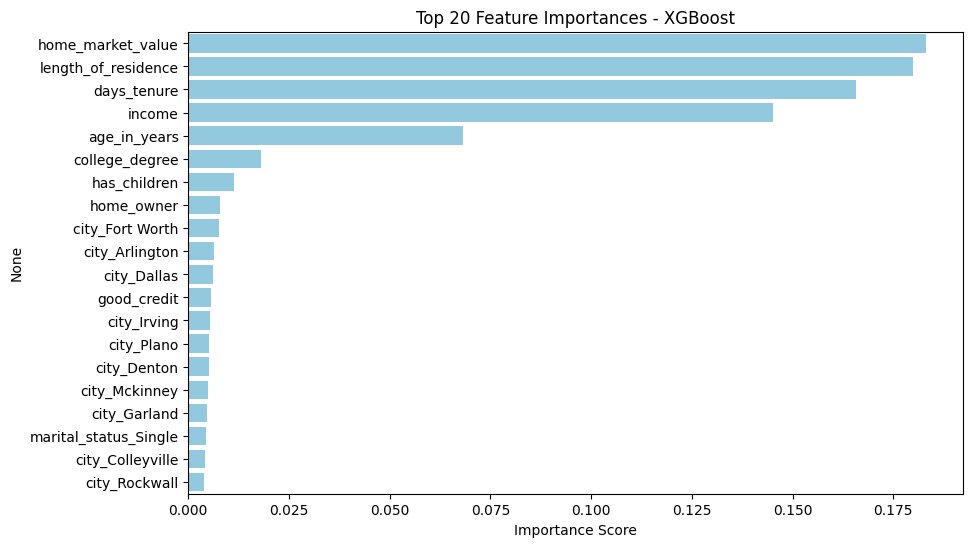


Example Customer → Churn Probability: 13.30%

💾 Model and Scaler saved successfully!


In [82]:
# -------------------------------
# FEATURE IMPORTANCE VISUALIZATION
# -------------------------------
feat_imp = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp[:20], y=feat_imp.index[:20], color='skyblue')
plt.title("Top 20 Feature Importances - XGBoost")
plt.xlabel("Importance Score")
plt.show()

# -------------------------------
# EXAMPLE PREDICTION
# -------------------------------
sample_customer = X_test.iloc[[0]]
pred_prob = xgb_model.predict_proba(sample_customer)[:, 1][0]
print(f"\nExample Customer → Churn Probability: {pred_prob*100:.2f}%")

# -------------------------------
# SAVE MODEL & SCALER
# -------------------------------
xgb_model.save_model("xgb_churn_model.json")
joblib.dump(scaler, "scaler.pkl")
print("\n💾 Model and Scaler saved successfully!")  